In [1]:
import os, sys
from pathlib import Path

src_path = Path(os.getcwd()).resolve().parents[1]  
sys.path.append(str(src_path))

print(sys.path[-1])  
import os
print(os.getcwd())

/Users/seobi/PythonProjects/RAG_Commander/src
/Users/seobi/PythonProjects/RAG_Commander/src/agents/main


In [2]:
%%writefile main_agent.py
from langchain_openai import ChatOpenAI
from langgraph.graph.state import Command, Literal
from agents.state.start_state import StartConfirmation, StartInput
from agents.state.main_state import MainState
from utils.llm import LLMProfile
from utils.util import get_today_str
from langchain_core.messages import HumanMessage, get_buffer_string, AIMessage
from langgraph.graph import StateGraph, START, END
from prompts import PromptManager, PromptType
from agents.analysis.analysis_graph import analysis_graph
from agents.jung_min_jae.jung_min_jae_agent import report_graph
from copy import deepcopy

start_llm = LLMProfile.chat_bot_llm()
messages_key = MainState.KEY.messages
start_input_key = MainState.KEY.start_input
analysis_outputs_key = MainState.KEY.analysis_outputs
status_key = MainState.KEY.status


def start_confirmation(
    state: MainState,
) -> Command[Literal["start", "__end__"]]:

    parser_llm = start_llm.with_structured_output(StartConfirmation)
    messages_str = get_buffer_string(messages=state[messages_key])

    prompt = PromptManager(PromptType.MAIN_START_CONFIRMATION).get_prompt(
        messages=messages_str
    )
    response: StartConfirmation = parser_llm.invoke([HumanMessage(content=prompt)])

    if response.confirm == False:
        return Command(
            goto=END, update={messages_key: [AIMessage(content=response.question)]}
        )
    else:
        return Command(
            goto="start",
            update={messages_key: [AIMessage(content=response.verification)]},
        )


def start(state: MainState) -> MainState:
    parser_model = start_llm.with_structured_output(StartInput)
    prompt = PromptManager(PromptType.MAIN_START).get_prompt(
        messages=get_buffer_string(state[messages_key]), date=get_today_str()
    )
    response: StartInput = parser_model.invoke([HumanMessage(content=prompt)])
    return {start_input_key: response.model_dump(), status_key: "ANALYSIS"}


def analysis_graph_node(state: MainState) -> MainState:
    result = analysis_graph.invoke({"start_input": deepcopy(state[start_input_key])})
    return {
        "analysis_outputs": result.get("analysis_outputs", {}),
        status_key: "JUNG_MIN_JAE"
    }


def jung_min_jae_graph(state: MainState) -> MainState:
    result = report_graph.invoke({"start_input": deepcopy(state[start_input_key]),
                                  "analysis_outputs": deepcopy(state[analysis_outputs_key]),
                                  "segment":1
                                  })
    return {
        "final_report": result["final_report"],
        status_key:"RENDERING"
    }


graph_builder = StateGraph(MainState)

start_confirmation_key = "start_confirmation"
start_key = "start"
analysis_graph_key = "analysis_graph"
jung_min_jae_key = "jung_min_jae_graph"

graph_builder.add_node(start_confirmation_key, start_confirmation)
graph_builder.add_node(start_key, start)
graph_builder.add_node(analysis_graph_key, analysis_graph_node)
graph_builder.add_node(jung_min_jae_key, jung_min_jae_graph)

graph_builder.add_edge(START, start_confirmation_key)
graph_builder.add_edge(start_key, analysis_graph_key)
graph_builder.add_edge(analysis_graph_key, jung_min_jae_key)
graph_builder.add_edge(analysis_graph_key, END)


Overwriting main_agent.py


/Users/seobi/PythonProjects/RAG_Commander/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


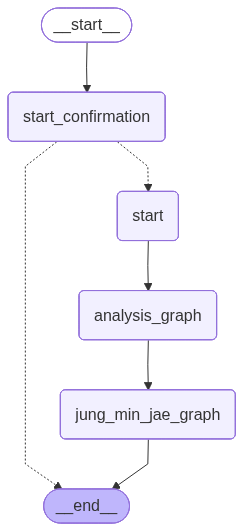

In [3]:
from main_agent import graph_builder
graph = graph_builder.compile()
graph

In [4]:
from utils.format_message import format_message
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import InMemorySaver
from agents.state.main_state import MainState
messages_key = MainState.KEY.messages
checkpointer = InMemorySaver()
graph = graph_builder.compile(checkpointer = checkpointer)

thread = {"configurable": {"thread_id":"1"}}
result = graph.invoke(
    {
        messages_key : [HumanMessage(content = "경기도 분당구 정자동 백현로 206 근처를 분석하고 싶고 규모는 대단지, 세대수는 1000세대 정도 생각합니다. ")]
    },
    config = thread
)

format_message(result[messages_key])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 경기도 분당구 정자동 백현로 206 근처를 분석하고 싶고 규모는 대단지, 세대수는 1000세대 정도 생각합니다.          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 제공해주신 정보(경기도 분당구 정자동 백현로 206 근처, 대단지, 약 1,000세대 규모)를 바탕으로 보고서 작성을       │
│ 시작하겠습니다. 요청하신 위치와 단지 규모, 세대수가 명확히 확인되었습니다. 지금부터 부동산 대행사 사내용        │
│ 보고서를 작성하겠습니다.                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [5]:
result

{'messages': [HumanMessage(content='경기도 분당구 정자동 백현로 206 근처를 분석하고 싶고 규모는 대단지, 세대수는 1000세대 정도 생각합니다. ', additional_kwargs={}, response_metadata={}, id='9eb9e79a-04cb-4a7e-8776-90a9d4385283'),
  AIMessage(content='제공해주신 정보(경기도 분당구 정자동 백현로 206 근처, 대단지, 약 1,000세대 규모)를 바탕으로 보고서 작성을 시작하겠습니다. 요청하신 위치와 단지 규모, 세대수가 명확히 확인되었습니다. 지금부터 부동산 대행사 사내용 보고서를 작성하겠습니다.', additional_kwargs={}, response_metadata={}, id='6b876489-3ba6-4885-9f45-01eb50f3cd71')],
 'start_input': {'target_area': '경기도 분당구 정자동 백현로 206 근처',
  'scale': '대단지',
  'total_units': 1000,
  'units_by_type': None,
  'brand': None,
  'orientation': None,
  'parking_ratio': None,
  'terrain_condition': None,
  'gross_area': None,
  'floor_area_ratio_range': None,
  'building_coverage_ratio_range': None},
 'analysis_outputs': {'economic_insight': '기준 정보\n- 대상지: 경기도 성남시 분당구 정자동 백현로 206 일대\n- 기준일: 2025-10-26 (Asia/Seoul, ISO8601)\n\n1) 금리/신용여건\n- 한국은행 기준금리(최근 12~13개월 시계열, 결정일/수준/출처)\n  - 2024-10-11: 3.25% (인하) [비공식 요약: 나무위키(2025-10-10 업데이트)]\n  

In [6]:
print(result['final_report'])

본 보고서는 부동산 마케팅 협회 리서치센터가 2025-10-26(Asia/Seoul) 기준 공개자료와 협회 산하 리서치팀 분석 결과를 교차 검증해 작성한 공식 문서입니다. 대상지는 경기도 성남시 분당구 정자동 백현로 206 인근(대단지·총 1,000세대 가정)입니다.

Executive Summary (BLUF)
- 권장 분양가 밴드(전용 84㎡, 옵션/VAT 제외): 5,800만~6,050만/3.3㎡(총액 약 14.9~15.6억). 대형 브랜드·역세권 도보·우수 커뮤니티 등 명확한 우위가 입증될 경우 5,950만~6,150만/3.3㎡(약 15.3~15.9억)까지 검토 가능. 중위 매매가 대비 +10% 초과(≈6,300만/3.3㎡ 이상)는 흡수력 저하 리스크가 커지므로 경고 구간으로 판단됨. [ref: rt.molit.go.kr, 2025-09; aptndm.com(2차집계), 2025-10]
- 근거: 반경 1km 1990년대 중반 준공 84㎡ 중위 평단이 약 5,729만/3.3㎡, 인근 준신축(더샵 분당파크리버 2021년)·2000년대(성원상떼뷰 2004년) 84㎡는 각각 약 6,020만·6,140만/3.3㎡로 확인되어 신규 분양의 상단을 사실상 제약. [ref: rt.molit.go.kr, 2024-10/2025-09; aptndm.com, 2025-10]
- 금리 국면(한국은행 기준금리 2.50% 유지)과 체감금리 하락은 이자부담을 경감해 분양가 수용력을 소폭 개선시키나, DSR 규제는 한도 측면 제약으로 작동할 가능성이 높음. 즉, 가격을 과도하게 올리는 전략은 전환률 하락으로 이어질 개연성이 큼. [ref: KBS 뉴스, 2025-05; EIEC KDI(한은 참고자료), 2025-08; TradingEconomics, 2025-10(비공식)]
- 입지의 구조적 장점(정자역 더블라인 접근성·판교테크노밸리 배후·생활편의)은 실수요 기반을 뒷받침하지만, 최근 2년 내 인근 신규 분양의 실증 레퍼런스가 부족해(자료 미확보) 가격·조건의 보수적 설정이 초기 